### First experiments with U-Net on real world slp data

Derived optimal masks for CESM and FOCI for 99.9% / 99% / 95% missing.

Now, try to transfer these masks to real world data.

**Note:** Have different grid structures. For FOCI, we have 96 x 192 lat-lon grid, with 18,432 grid points. 0.1% hence means 18 grid points. Whereas, for real world slp fields we use a 72 x 144 lat-lon grid, with only 10,368 grid points.

--> Look for the top 10 grid points from FOCI mean rel. loss reduction maps and transfer obtained mask to real world grid.

In [1]:
import os
import sys
sys.path.append('../reconstruct_missing_data')

from pathlib import Path
from json import dump, load

# # Next block for visualization, only if packeges are pre-installed!
# import xarray as xr
# import hvplot.xarray
# import geoviews as gv
# import cartopy
# import cartopy.crs as ccrs
# import cmocean

import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

from data_loading import find_data_files, load_data_set, get_anomalies, clone_data, create_missing_mask, split_and_scale_data, get_land_silhouette
from models import build_unet_4conv
from relevance import compute_single_relevance_map

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, concatenate, Conv1D, Conv2D, MaxPool2D, UpSampling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.utils import plot_model

# Suppress Tensorflow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
# Set working directory, according to working directory in scripts:
os.chdir('/gxfs_work1/geomar/smomw511') # nesh
# os.chdir('/Users/mlandt-hayen') # local
# os.chdir('/work') # local in Docker Container

In [4]:
## Reload parameters and results for experiment:

# Specify experiment:
model_config = 'unet_4conv'
feature = 'sea-level-pressure' # Choose either 'sea-level-pressure' or 'sea-surface-temperature' as feature.
feature_short = 'slp' # Free to set short name, to store results, e.g. 'slp' and 'sst'.
source = 'FOCI' # Choose Earth System Model, either 'FOCI' or 'CESM'.
mask_type = 'variable'
missing_type = 'range_50_999'
augmentation_factor = 3
run = '_final'
exp_name = '/relevance_2'

# Get path to stored results:
path_to_stored_results = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'
                      +mask_type+'_'+missing_type+'_factor_'+str(augmentation_factor)+run+exp_name)

print(path_to_stored_results)

# Reload parameters relevant for data pre-processing for this experiment:
with open(path_to_stored_results / 'parameters.json', 'r') as f:
    parameters=load(f)


train_val_split = parameters['train_val_split']
scale_to = parameters['scale_to']
n_samples = parameters['n_samples']
patch_size = parameters['patch_size']
max_patch_num = parameters['max_patch_num']
max_acc_rel_loss_reduction = parameters['max_acc_rel_loss_reduction']

# Print parameters:
print("\nnumber of samples: ", n_samples)
print("patch size: ", patch_size)
print("max. number of patches to include: ", max_patch_num)
print("max. acc. rel. loss as threshold: ", max_acc_rel_loss_reduction)

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_FOCI_variable_range_50_999_factor_3_final/relevance_2

number of samples:  120
patch size:  1
max. number of patches to include:  184
max. acc. rel. loss as threshold:  0.99


In [5]:
# # Get path to model:
# path_to_model = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'
#                       +mask_type+'_'+missing_type+'_factor_'+str(augmentation_factor)+run)

# # Reload final model, trained on range:
# model = tf.keras.models.load_model(path_to_model / 'missing_0_100' / 'model')

2023-03-08 09:35:31.178447: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /.singularity.d/libs
2023-03-08 09:35:31.178469: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-08 09:35:31.178480: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (neshcl211): /proc/driver/nvidia/version does not exist
2023-03-08 09:35:31.178655: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# ## Prepare validation samples:

# # Path to full data:
# #path_to_data = 'climate_index_collection/data/raw/2022-08-22/'
# path_to_data = 'GitHub/MarcoLandtHayen/reconstruct_missing_data/data/test_data/'

# # Load data:
# data_raw = load_data_set(data_path=path_to_data, data_source_name=source)

# # Select single feature and compute anomalies, using whole time span as climatology:
# data = get_anomalies(feature=feature, data_set=data_raw)

# # Create synthetic missing_mask of ONEs, to load FULL validation samples:
# missing_mask_1 = (np.ones(data.shape)==1)

# # Get scaled validation inputs and targets. Note: Using missing_mask of ONEs, validation inputs and targets are 
# # identical. Only difference is found in dimensionality: inputs have channel number (=1) as final dimension, targets don't.
# train_input, val_input, _, _, train_min, train_max, _, _ = split_and_scale_data(
#     data, 
#     missing_mask_1,
#     train_val_split, 
#     scale_to
# )

/app/conda/lib/python3.8/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/app/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


In [6]:
# Get possible number of patches in lat and lon directions, respectively:
n_lat = int(val_input[0:1].shape[1] / patch_size)
n_lon = int(val_input[0:1].shape[2] / patch_size)

# Obtain total number of patches:
n_patches = int(n_lat * n_lon)

# If max. number of patches to include is given as -1, set to total number of possible patches:
if max_patch_num == -1:
    max_patch_num = n_patches

In [7]:
# Reload results for this experiment:
rel_loss_reduction_maps = np.load(path_to_stored_results / "rel_loss_reduction_maps.npy")
patch_orders = np.load(path_to_stored_results / "patch_orders.npy")
abs_loss_reductions = np.load(path_to_stored_results / "abs_loss_reductions.npy")
rel_loss_reductions = np.load(path_to_stored_results / "rel_loss_reductions.npy")
acc_rel_loss_reductions = np.load(path_to_stored_results / "acc_rel_loss_reductions.npy")

In [8]:
## Optionally pick only subset of samples:

# # Define starting point(s) and number of samples to consider at each starting point:
# n_start_1 = 0
# n_start_2 = 900
# n_samples = 300

# # In case, only one starting point is defined:
# rel_loss_reduction_maps = rel_loss_reduction_maps[n_start_1:n_start_1+n_samples]
# patch_orders = patch_orders[n_start_1:n_start_1+n_samples]
# abs_loss_reductions = abs_loss_reductions[n_start_1:n_start_1+n_samples]
# rel_loss_reductions = rel_loss_reductions[n_start_1:n_start_1+n_samples]
# acc_rel_loss_reductions = acc_rel_loss_reductions[n_start_1:n_start_1+n_samples]

# # For two distincd starting points:
# rel_loss_reduction_maps = np.concatenate([rel_loss_reduction_maps[n_start_1:n_start_1+n_samples],
#                                           rel_loss_reduction_maps[n_start_2:n_start_2+n_samples]], axis=0)
# patch_orders = np.concatenate([patch_orders[n_start_1:n_start_1+n_samples],
#                                           patch_orders[n_start_2:n_start_2+n_samples]], axis=0)
# abs_loss_reductions = np.concatenate([abs_loss_reductions[n_start_1:n_start_1+n_samples],
#                                           abs_loss_reductions[n_start_2:n_start_2+n_samples]], axis=0)
# rel_loss_reductions = np.concatenate([rel_loss_reductions[n_start_1:n_start_1+n_samples],
#                                           rel_loss_reductions[n_start_2:n_start_2+n_samples]], axis=0)
# acc_rel_loss_reductions = np.concatenate([acc_rel_loss_reductions[n_start_1:n_start_1+n_samples],
#                                           acc_rel_loss_reductions[n_start_2:n_start_2+n_samples]], axis=0)

# # Double number of samples, to have n_samples reflect the correct number of samples:
# n_samples = n_samples * 2

print("rel_loss_reduction_maps:", rel_loss_reduction_maps.shape)
print("patch_orders:", patch_orders.shape)
print("rel_loss_reductions:", rel_loss_reductions.shape)
print("abs_loss_reductions:", abs_loss_reductions.shape)
print("acc_rel_loss_reductions:", acc_rel_loss_reductions.shape)

rel_loss_reduction_maps: (120, 96, 192)
patch_orders: (120, 18432)
rel_loss_reductions: (120, 18432)
abs_loss_reductions: (120, 18432)
acc_rel_loss_reductions: (120, 18432)


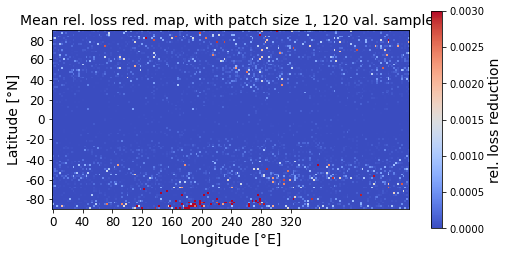

In [10]:
## range_50_999, relevance_2: TRAINING samples!
# Include 120 samples, 60 from both edges of the time line.
# patch_size = 1
# max_patch_num = 184
# max_acc_rel_loss_reduction = 0.99

# Compute mean of rel. loss reduction maps, over desired number of considered validation samples:
mean_rel_loss_reduction_map = np.mean(rel_loss_reduction_maps[:n_samples],axis=0)

# Plot resulting mean rel. loss reduction map as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(mean_rel_loss_reduction_map, cmap="coolwarm", interpolation='nearest', vmax=0.003)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(n_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

### Clustering with GMM to find optimal masks

#### 99.9% missing

In [11]:
# Look for number of grid points in mean rel. loss reduction map with non-zero entry:
print("non-zero entries in mean rel. loss reduction map: ", np.sum(mean_rel_loss_reduction_map!=0))

## Start with 3D clustering of x/y positions and its rel. loss reduction (z) for non-zero entries:
## Optionally cut of noise in mean rel. loss reduction map:

# Set threshold:
noise_threshold = 0.001

# Compute max. rel. loss reduction, for scaling of z-component:
max_rel_loss_red = np.max(mean_rel_loss_reduction_map)

# Create tuples of x/y/z positions:
xyz = []

# Loop over longitude:
for x in range(n_lon):
    
    # Loop over latitude:
    for y in range(n_lat):
        
        # Check for non-zero entry in mean rel. loss reduction map:
        if mean_rel_loss_reduction_map[y,x] > noise_threshold:
            
#         # Alternatively check for grid points, that exceed threshold in patch_counts:
#         if patch_counts_2D[y,x] > 5:
            
            # Store xyz-tuple, scaled to [0,1] in either dimension:
            xyz.append([x/(n_lon-1), y/(n_lat-1), mean_rel_loss_reduction_map[y,x]/max_rel_loss_red])

# Convert list of xyz-tuples to np.array:
xyz = np.array(xyz)

# Output number of obtained tuples:
print("number of xyz-tuples representing non-zero entries in mean rel. loss reduction map: ", len(xyz))

# Get clusters from GMM algorithms with pre-specified number of clusters = 10 (=0.1% for RW slp grid).
# Note: Only use positional features (lat and lon), omit mean rel. loss reduction as feature:
GMM_999 = GaussianMixture(n_components=10, random_state=0).fit(xyz[:,:2])

# Get clusters:
GMM_999_clusters = GMM_999.predict(xyz[:,:2])

non-zero entries in mean rel. loss reduction map:  5232
number of xyz-tuples representing non-zero entries in mean rel. loss reduction map:  213


In [12]:
## Convert obtained cluster means to real world lat/lon scales:

# Note: slp real world fields come on 73 x 144 lat-lon-grid. Truncated to 72 x 144, to make them fit to U-Net with 4 convolutions.
# For rescaling, need original dimensions, to transfer grid correctly.
n_lat_realworld = 73
n_lon_realworld = 144

# Initialize storage:
cluster_means_999_GMM = np.zeros(GMM_999.means_.shape).astype(int)

# Unscale latitude and longitude dimensions:
cluster_means_999_GMM[:,0] = np.round(GMM_999.means_[:,0]*(n_lon_realworld-1),0).astype(int)
cluster_means_999_GMM[:,1] = np.round(GMM_999.means_[:,1]*(n_lat_realworld-1),0).astype(int)

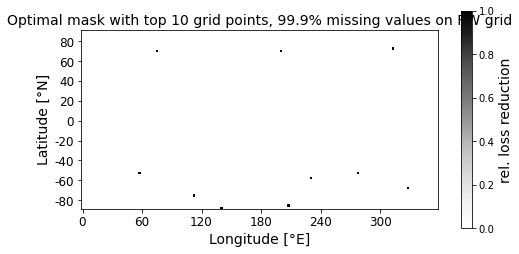

In [13]:
## Create optimal mask from cluster means:

# Initialize two-dimensional boolean mask of FALSE, dimension (n_lat, n_lon):
mask_999_GMM = (np.zeros((n_lat_realworld,n_lon_realworld))!=0)

# Loop over cluster centers:
for xyz in cluster_means_999_GMM:
    
    # Set grid points to True:
    mask_999_GMM[xyz[1],xyz[0]]=True

# Truncate mask to fit dimensions, used to train models: Omit last row and last four columns, to fit requirements for U-Net:
mask_999_GMM = mask_999_GMM[:-1,:]

# Plot optimal mask:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(mask_999_GMM, cmap="Greys", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Optimal mask with top 10 grid points, 99.9% missing values on RW grid', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=24), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks(np.arange(4, 72, step=8), [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [15]:
# Set path to store optimal missing masks:
path_to_store_masks = Path(
    'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'+
    mask_type+'_'+missing_type+'_factor_'+str(augmentation_factor)+run+exp_name)

print(path_to_store_masks)

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_FOCI_variable_range_50_999_factor_3_final/relevance_2


In [16]:
## Store masks, to re-use in batch:
#np.save(path_to_store_masks / "optimal_sampling_mask_999_realworld.npy", mask_999_GMM)

#### 99% missing

non-zero entries in mean rel. loss reduction map:  5232
noise threshold: 0.0005
number of xyz-tuples representing non-zero entries in mean rel. loss reduction map:  409


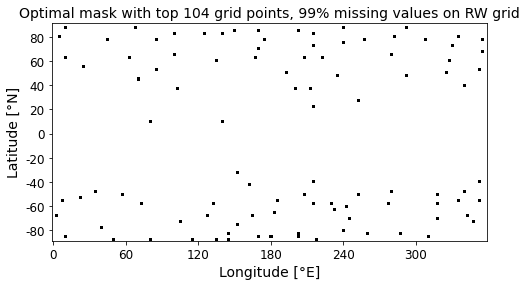

In [18]:
# Look for number of grid points in mean rel. loss reduction map with non-zero entry:
print("non-zero entries in mean rel. loss reduction map: ", np.sum(mean_rel_loss_reduction_map!=0))

## Start with 3D clustering of x/y positions and its rel. loss reduction (z) for non-zero entries:
## Optionally cut of noise in mean rel. loss reduction map:

# Set threshold:
noise_threshold = 0.0005

print('noise threshold:',noise_threshold)

# Compute max. rel. loss reduction, for scaling of z-component:
max_rel_loss_red = np.max(mean_rel_loss_reduction_map)

# Create tuples of x/y/z positions:
xyz = []

# Loop over longitude:
for x in range(n_lon):
    
    # Loop over latitude:
    for y in range(n_lat):
        
        # Check for non-zero entry in mean rel. loss reduction map:
        if mean_rel_loss_reduction_map[y,x] > noise_threshold:
            
#         # Alternatively check for grid points, that exceed threshold in patch_counts:
#         if patch_counts_2D[y,x] > 5:
            
            # Store xyz-tuple, scaled to [0,1] in either dimension:
            xyz.append([x/(n_lon-1), y/(n_lat-1), mean_rel_loss_reduction_map[y,x]/max_rel_loss_red])

# Convert list of xyz-tuples to np.array:
xyz = np.array(xyz)

# Output number of obtained tuples:
print("number of xyz-tuples representing non-zero entries in mean rel. loss reduction map: ", len(xyz))

# Get clusters from GMM algorithms with pre-specified number of clusters = 104 (=1% for RW slp grid).
# Note: Only use positional features (lat and lon), omit mean rel. loss reduction as feature:
GMM_99 = GaussianMixture(n_components=104, random_state=0).fit(xyz[:,:2])

# Get clusters:
GMM_99_clusters = GMM_99.predict(xyz[:,:2])

## Convert obtained cluster means to real world lat/lon scales:

# Note: slp real world fields come on 73 x 144 lat-lon-grid. Truncated to 72 x 144, to make them fit to U-Net with 4 convolutions.
# For rescaling, need original dimensions, to transfer grid correctly.
n_lat_realworld = 73
n_lon_realworld = 144

# Initialize storage:
cluster_means_99_GMM = np.zeros(GMM_99.means_.shape).astype(int)

# Unscale latitude and longitude dimensions:
cluster_means_99_GMM[:,0] = np.round(GMM_99.means_[:,0]*(n_lon_realworld-1),0).astype(int)
cluster_means_99_GMM[:,1] = np.round(GMM_99.means_[:,1]*(n_lat_realworld-1),0).astype(int)

## Create optimal mask from cluster means:

# Initialize two-dimensional boolean mask of FALSE, dimension (n_lat, n_lon):
mask_99_GMM = (np.zeros((n_lat_realworld,n_lon_realworld))!=0)

# Loop over cluster centers:
for xyz in cluster_means_99_GMM:
    
    # Set grid points to True:
    mask_99_GMM[xyz[1],xyz[0]]=True

# Truncate mask to fit dimensions, used to train models: Omit last row and last four columns, to fit requirements for U-Net:
mask_99_GMM = mask_99_GMM[:-1,:]

# Plot optimal mask:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(mask_99_GMM, cmap="Greys", interpolation='nearest')#, vmax=0.00022)
#cbar = plt.colorbar(im)
#cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Optimal mask with top 104 grid points, 99% missing values on RW grid', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=24), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks(np.arange(4, 72, step=8), [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [19]:
# Set path to store optimal missing masks:
path_to_store_masks = Path(
    'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'+
    mask_type+'_'+missing_type+'_factor_'+str(augmentation_factor)+run+exp_name)

print(path_to_store_masks)

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_FOCI_variable_range_50_999_factor_3_final/relevance_2


In [20]:
## Store masks, to re-use in batch:
#np.save(path_to_store_masks / "optimal_sampling_mask_99_realworld.npy", mask_99_GMM)

#### 95% missing

non-zero entries in mean rel. loss reduction map:  5232
noise threshold: 0.0
number of xyz-tuples representing non-zero entries in mean rel. loss reduction map:  5232


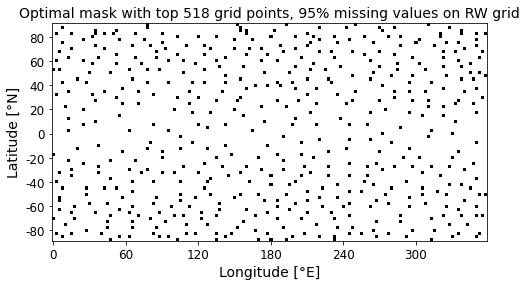

In [21]:
# Look for number of grid points in mean rel. loss reduction map with non-zero entry:
print("non-zero entries in mean rel. loss reduction map: ", np.sum(mean_rel_loss_reduction_map!=0))

## Start with 3D clustering of x/y positions and its rel. loss reduction (z) for non-zero entries:
## Optionally cut of noise in mean rel. loss reduction map:

# Set threshold:
noise_threshold = 0.0

print('noise threshold:',noise_threshold)

# Compute max. rel. loss reduction, for scaling of z-component:
max_rel_loss_red = np.max(mean_rel_loss_reduction_map)

# Create tuples of x/y/z positions:
xyz = []

# Loop over longitude:
for x in range(n_lon):
    
    # Loop over latitude:
    for y in range(n_lat):
        
        # Check for non-zero entry in mean rel. loss reduction map:
        if mean_rel_loss_reduction_map[y,x] > noise_threshold:
            
#         # Alternatively check for grid points, that exceed threshold in patch_counts:
#         if patch_counts_2D[y,x] > 5:
            
            # Store xyz-tuple, scaled to [0,1] in either dimension:
            xyz.append([x/(n_lon-1), y/(n_lat-1), mean_rel_loss_reduction_map[y,x]/max_rel_loss_red])

# Convert list of xyz-tuples to np.array:
xyz = np.array(xyz)

# Output number of obtained tuples:
print("number of xyz-tuples representing non-zero entries in mean rel. loss reduction map: ", len(xyz))

# Get clusters from GMM algorithms with pre-specified number of clusters = 518 (=5% for RW slp grid).
# Note: Only use positional features (lat and lon), omit mean rel. loss reduction as feature:
GMM_95 = GaussianMixture(n_components=518, random_state=0).fit(xyz[:,:2])

# Get clusters:
GMM_95_clusters = GMM_95.predict(xyz[:,:2])

## Convert obtained cluster means to real world lat/lon scales:

# Note: slp real world fields come on 73 x 144 lat-lon-grid. Truncated to 72 x 144, to make them fit to U-Net with 4 convolutions.
# For rescaling, need original dimensions, to transfer grid correctly.
n_lat_realworld = 73
n_lon_realworld = 144

# Initialize storage:
cluster_means_95_GMM = np.zeros(GMM_95.means_.shape).astype(int)

# Unscale latitude and longitude dimensions:
cluster_means_95_GMM[:,0] = np.round(GMM_95.means_[:,0]*(n_lon_realworld-1),0).astype(int)
cluster_means_95_GMM[:,1] = np.round(GMM_95.means_[:,1]*(n_lat_realworld-1),0).astype(int)

## Create optimal mask from cluster means:

# Initialize two-dimensional boolean mask of FALSE, dimension (n_lat, n_lon):
mask_95_GMM = (np.zeros((n_lat_realworld,n_lon_realworld))!=0)

# Loop over cluster centers:
for xyz in cluster_means_95_GMM:
    
    # Set grid points to True:
    mask_95_GMM[xyz[1],xyz[0]]=True

# Truncate mask to fit dimensions, used to train models: Omit last row and last four columns, to fit requirements for U-Net:
mask_95_GMM = mask_95_GMM[:-1,:]

# Plot optimal mask:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(mask_95_GMM, cmap="Greys", interpolation='nearest')#, vmax=0.00022)
#cbar = plt.colorbar(im)
#cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Optimal mask with top 518 grid points, 95% missing values on RW grid', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=24), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks(np.arange(4, 72, step=8), [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [22]:
# Set path to store optimal missing masks:
path_to_store_masks = Path(
    'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'+
    mask_type+'_'+missing_type+'_factor_'+str(augmentation_factor)+run+exp_name)

print(path_to_store_masks)

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_FOCI_variable_range_50_999_factor_3_final/relevance_2


In [23]:
## Store masks, to re-use in batch:
#np.save(path_to_store_masks / "optimal_sampling_mask_95_realworld.npy", mask_95_GMM)